<a href="https://colab.research.google.com/github/shivampatel057/lisfranccnn/blob/main/Pytorch_DenseNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pytorch-ignite

In [2]:
#!tar -xf /content/drive/MyDrive/LFcnn.tar

In [3]:
def get_data_loaders(data_dir, batch_size):
  transform = transforms.Compose([transforms.Resize(255),
                                  transforms.RandomRotation(10),
                                  transforms.CenterCrop(224),
                                  transforms.ToTensor()])
  all_images = datasets.ImageFolder(data_dir, transform=transform)
  train_images_len = int(len(all_images) * 0.8)
  val_images_len = int((len(all_images) - train_images_len)/4)
  test_images_len = int((len(all_images) - train_images_len - val_images_len))
  train_data, val_data, test_data = random_split(all_images, [train_images_len, val_images_len, test_images_len])
  train_loader = DataLoader(train_data, batch_size=batch_size)
  val_loader = DataLoader(val_data, batch_size=batch_size)
  test_loader = DataLoader(test_data, batch_size=batch_size)
  return (train_loader, val_loader, test_loader), all_images.classes

In [4]:
import torch
import torchvision
from torchvision import datasets, transforms
from torch import nn, optim #NN module, optimize[train_images_;len, val]
from torch.nn import functional as F #sigmoid, tanh, relu
from torch.utils.data import DataLoader, sampler, random_split
from torchvision import models

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina' #for retina displays

In [6]:
import numpy as np

In [7]:
from ignite.engine import Engine, Events, create_supervised_trainer, create_supervised_evaluator
from ignite.handlers import ModelCheckpoint, EarlyStopping
from ignite.metrics import Accuracy, Loss, RunningAverage, ConfusionMatrix

In [8]:
(train_loader, val_loader, test_loader), classes = get_data_loaders("/content/drive/MyDrive/LFcnn", 64)

In [9]:
print(classes)

['001.injured', '002.intact']


In [10]:
#helper fxn for text
import re
formatText= lambda string: string[4:].replace("-", " ")
print(formatText(classes[0]))

injured


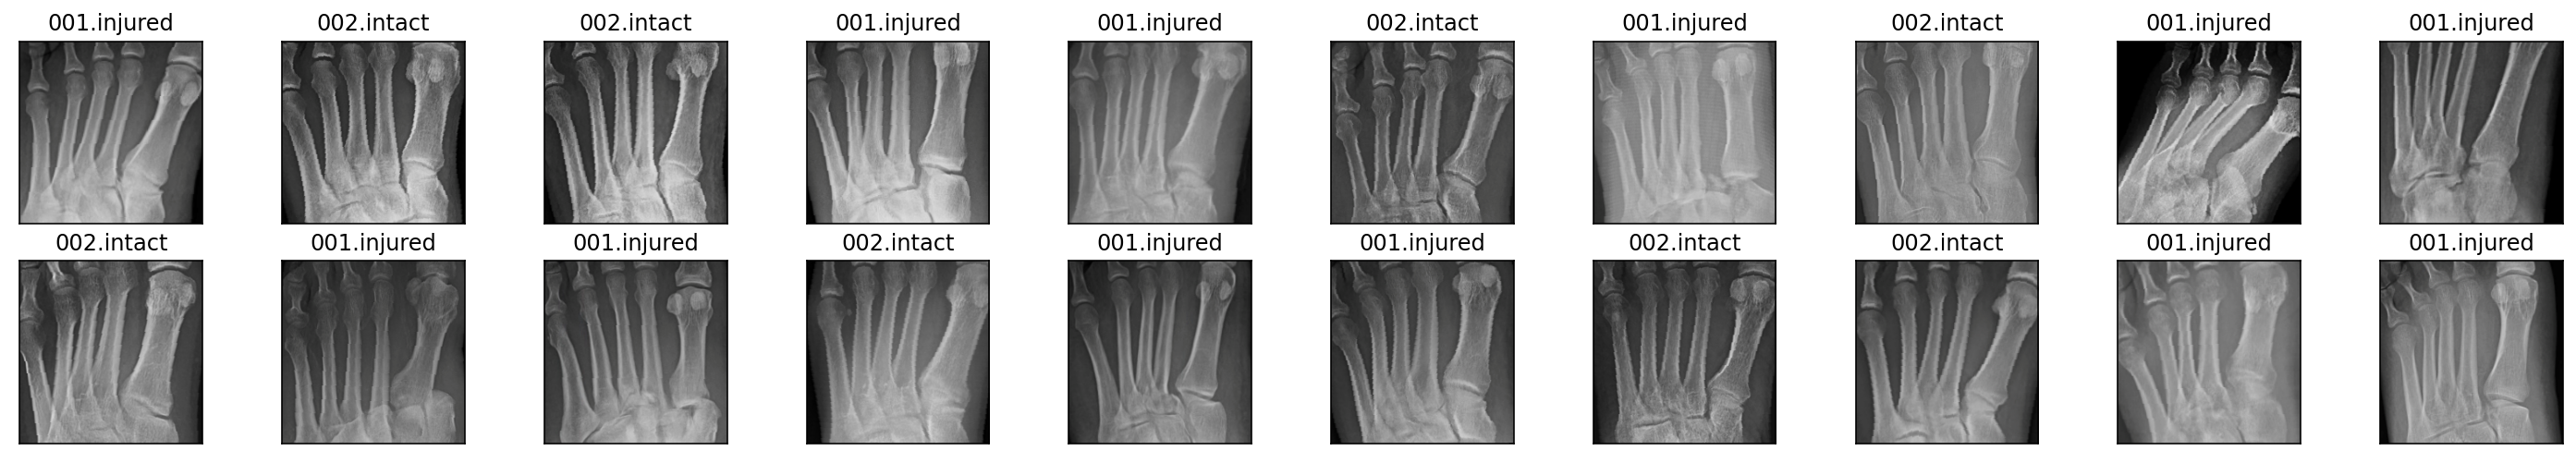

In [11]:
#display training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

fig=plt.figure(figsize=(25, 4))
for idx in np.arange(20):
  ax = fig.add_subplot(2, 20/2, idx + 1, xticks=[], yticks=[])
  plt.imshow(np.transpose(images[idx], (1, 2, 0)))
  ax.set_title(classes[labels[idx]])

In [12]:
#load model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

In [13]:
model = models.densenet121(pretrained=True)

In [14]:
#print(model)

In [15]:
#last layer output shape
print(model.classifier.in_features)
print(model.classifier.out_features)

1024
1000


In [16]:
for param in model.parameters():
  param.requires_grad = False #freze model since its trained on imagenet

In [17]:
n_inputs = model.classifier.in_features
last_layer = nn.Linear(n_inputs, len(classes))
model.classifier = last_layer
print(model.classifier.out_features)


2


In [18]:
#move to GPU
model = model.to(device)

In [19]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters())

In [20]:
#training
training_history = {'accuracy':[], 'loss':[]}
validation_history = {'accuracy':[], 'loss':[]}

In [21]:
#ignite
trainer = create_supervised_trainer(model, optimizer, criterion, device=device)
evaluator = create_supervised_evaluator(model,
                                        device=device,
                                        metrics={
                                            'accuracy':Accuracy(),
                                            'loss':Loss(criterion),
                                            'cm':ConfusionMatrix(len(classes))
                                        })
@trainer.on(Events.ITERATION_COMPLETED)
def log_a_dot(engine):
  print(".", end="")

@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    evaluator.run(train_loader)
    metrics = evaluator.state.metrics
    accuracy = metrics['accuracy']*100
    loss = metrics['loss']
    training_history['accuracy'].append(accuracy)
    training_history['loss'].append(loss)
    print()
    print(f"Training results - Epoch: {trainer.state.epoch} Avg accuracy: {accuracy} Loss: {loss}") 

@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(trainer):
    evaluator.run(val_loader)
    metrics = evaluator.state.metrics
    accuracy = metrics['accuracy']*100
    loss = metrics['loss']
    validation_history['accuracy'].append(accuracy)
    validation_history['loss'].append(loss)
    print()
    print(f"Validation results - Epoch: {trainer.state.epoch} Avg accuracy: {accuracy} Loss: {loss}")                                       

In [22]:
trainer.run(train_loader, max_epochs=50)

.....
Training results - Epoch: 1 Avg accuracy: 55.27272727272727 Loss: 0.6784250710227273

Validation results - Epoch: 1 Avg accuracy: 64.70588235294117 Loss: 0.6457526263068704
.....
Training results - Epoch: 2 Avg accuracy: 49.81818181818182 Loss: 0.7171946022727272

Validation results - Epoch: 2 Avg accuracy: 58.82352941176471 Loss: 0.6583586300120634
.....
Training results - Epoch: 3 Avg accuracy: 43.63636363636363 Loss: 0.7777901389382103

Validation results - Epoch: 3 Avg accuracy: 41.17647058823529 Loss: 0.7563523685230928
.....
Training results - Epoch: 4 Avg accuracy: 54.90909090909091 Loss: 0.6867438299005681

Validation results - Epoch: 4 Avg accuracy: 64.70588235294117 Loss: 0.6481428707347197
.....
Training results - Epoch: 5 Avg accuracy: 50.18181818181818 Loss: 0.7146444424715909

Validation results - Epoch: 5 Avg accuracy: 64.70588235294117 Loss: 0.6826760348151711
.....
Training results - Epoch: 6 Avg accuracy: 53.45454545454545 Loss: 0.70031494140625

Validation resu

State:
	iteration: 250
	epoch: 50
	epoch_length: 5
	max_epochs: 50
	output: 0.2022043615579605
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

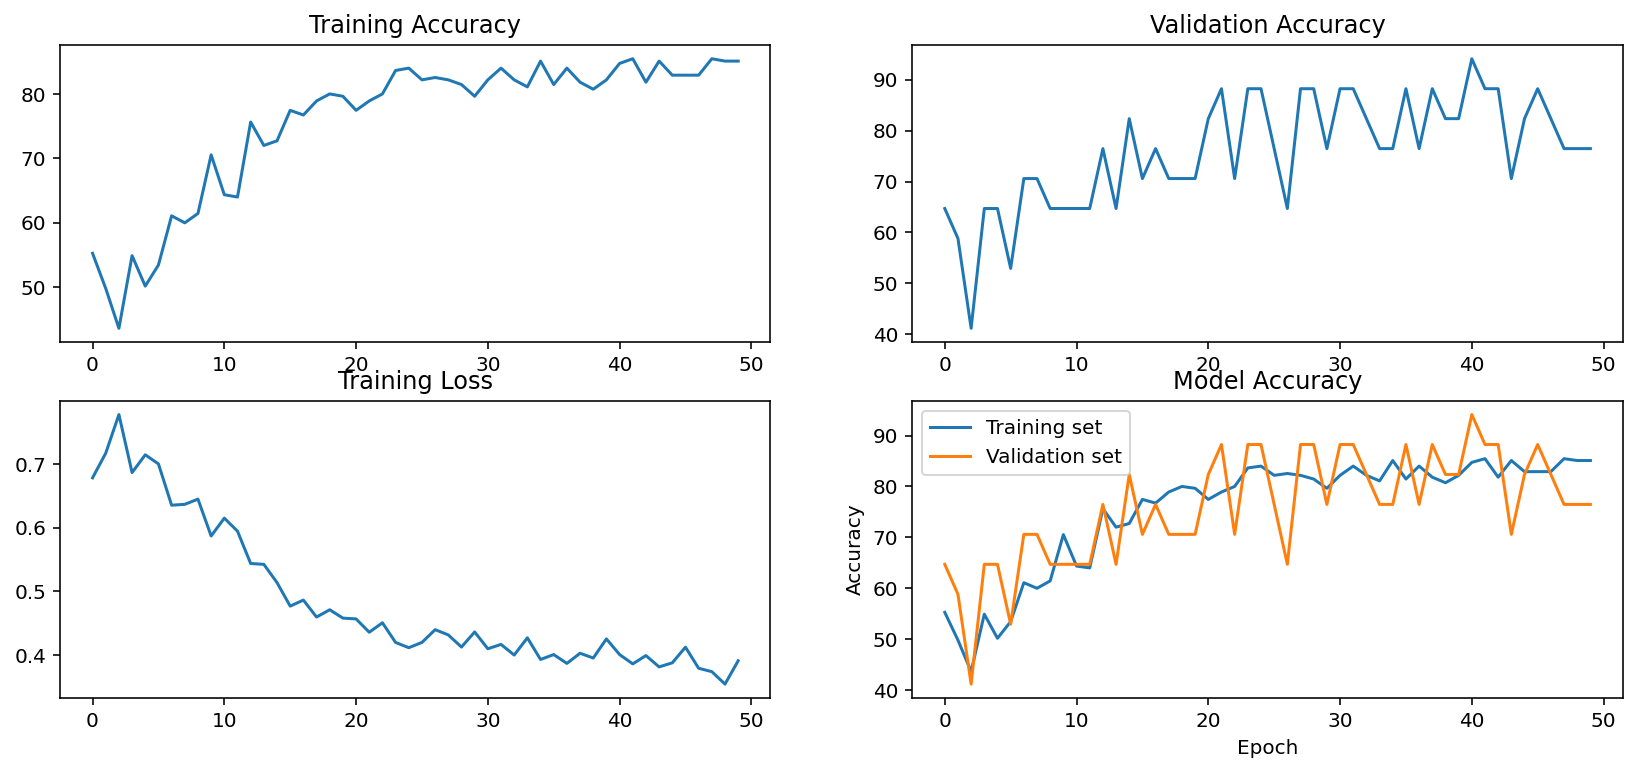

In [23]:
#testing loss vs acc
fig, axs = plt.subplots(2, 2)
fig.set_figheight(6)
fig.set_figwidth(14)
axs[0, 0].plot(training_history["accuracy"])
axs[0, 0].set_title("Training Accuracy")
axs[0, 1].plot(validation_history["accuracy"])
axs[0, 1].set_title("Validation Accuracy")
axs[1, 0].plot(training_history["loss"])
axs[1, 0].set_title("Training Loss")
#axs[1, 1].plot(validation_history["loss"])
#axs[1, 1].set_title("Validation Loss")

plt.plot((training_history)["accuracy"])
plt.plot(validation_history['accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training set', 'Validation set'], loc='upper left')
plt.show()

In [24]:
import re
test_loss = 0.0
class_correct = np.zeros(len(classes))
class_total = np.zeros(len(classes))
model.eval()

for data, target in test_loader:
  if torch.cuda.is_available():
    data, target = data.cuda(), target.cuda()
  output = model(data)
  loss = criterion(output, target)
  test_loss += loss.item()*data.size(0)
  _, pred = torch.max(output, 1)
  correct_tensor = pred.eq(target.data.view_as(pred))
  correct = np.squeeze(correct_tensor.numpy()) if not torch.cuda.is_available() else np.squeeze(correct_tensor.cpu().numpy())
  #convert GPU to CPU
  if len(target) == 52:
    for i in range(52):
      label = target.data[i]
      class_correct[label] += correct[i].item()
      class_total[label] += 1
test_loss /= len(test_loader.dataset)
print("Test Loss: {:.6f}\n".format(test_loss))
 
for i in range(len(classes)):
 # if class_total[i] > 0:
  print("Test Accuracy of {}: {} ({}/{})".format(
      classes[i], 100*class_correct[i] / class_total[i],
      np.sum(class_correct[i]), np.sum(class_total[i])
      #class_correct[i], class_total[i]
    ))
 

Test Loss: 0.374311

Test Accuracy of 001.injured: 84.0 (21.0/25.0)
Test Accuracy of 002.intact: 96.29629629629629 (26.0/27.0)


In [25]:
print(len(test_loader.dataset))

52


In [41]:
print(len(train_loader.dataset))

275


In [42]:
print(len(val_loader.dataset))

17


In [27]:
from PIL import Image
import requests
from io import BytesIO

In [28]:
def apply_test_transforms(inp):
    out = transforms.functional.resize(inp, [255])
    out = transforms.functional.to_tensor(out)
    out = transforms.functional.normalize(out, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    return out

In [29]:
def predict(model, filepath, show_img=False, url=False):
  if url:
    response = requests.get(filepath)
    im = Image.open(BytesIO(response.content))
  else:
    im = Image.open(filepath)
  if show_img:
    plt.imshow(im)
  im_as_tensor = apply_test_transforms(im)
  minibatch = torch.stack([im_as_tensor])
  if torch.cuda.is_available():
    minibatch = minibatch.cuda()
  pred = model(minibatch)
  __,classnum = torch.max(pred, 1)
  return formatText(classes[classnum])

In [48]:
torch.save(model.state_dict(), 'LFcnnDensenet121.pth')

In [32]:
#predict(model, "", show_img=True, url=True)

In [33]:
#predict(model, "", show_img=True, url=True)

In [34]:
#predict(model, "", show_img=True, url=True)

In [35]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from google.colab import files
from keras.preprocessing import image

#uploaded = files.upload()

#predict(model, filepath, show_img=True, url=False)

In [36]:
#metrics
import tensorflow as tf
import numpy as np
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score


In [37]:
#from sklearn.metrics import confusion_matrix
#tick_labels = ['Injured', 'Intact']

#cm = confusion_matrix(training_history, 'accuracy')
#ax = sns.heatmap(cm, annot=True, fmt="d")
#plt.ylabel('Actual')
#plt.xlabel('Predicted')
#ax.set_xticklabels(tick_labels)
#ax.set_yticklabels(tick_labels)

In [38]:
#fpr, tpr, _ = roc_curve(test_loader, preds)

In [39]:
#roc_auc = auc(fpr, tpr)

In [40]:
#plt.figure()
#lw = 2
#plt.plot(fpr, tpr, color='darkorange',
#         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
#plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
#plt.xlim([0.0, 1.0])
#plt.ylim([0.0, 1.05])
#plt.xlabel('False Positive Rate')
#plt.ylabel('True Positive Rate')
#plt.title('Receiver Operating Characteristic')
#plt.legend(loc="lower right")
#plt.show()